In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ast
from itertools import zip_longest

In [2]:
import ast
import os
import pandas as pd
import json
from collections import defaultdict

def get_llm_ratings(llm_rating_sources: list[str]) -> dict[str, dict[str, list[float]]]:
    llm_ratings = defaultdict(lambda: defaultdict(list))  

    for source in llm_rating_sources:
        source_path = f"{os.path.dirname(os.path.abspath(os.getcwd()))}/../outputs/{source}"
        
        for root, _, files in os.walk(source_path):
            model_name = os.path.basename(os.path.dirname(root))
            
            for file in files:
                if file.endswith(".csv"):
                    file_path = os.path.join(root, file)
                    df = pd.read_csv(file_path, header=None, names=['experiment_name', 'version', 'response'])

                    for _, row in df.iterrows():
                        experiment_name = row["experiment_name"]
                        version = row["version"]
                        response = row["response"]
                        
                        try:
                            
                            response_dict = json.loads(response.replace("'", "\""))
                        except json.JSONDecodeError:
                            try:
                                response_dict = ast.literal_eval(response)
                            except (ValueError, SyntaxError):

                                continue  

                        value_at_key_1 = response_dict.get('1')

                        if value_at_key_1 is not None:
                            llm_ratings[model_name][experiment_name + ", " + version] = value_at_key_1

    return llm_ratings

In [3]:
human_ratings = { # Standard suspense / Q2 ratings
    "Experiment A, Pen Not Mentioned": (3.78 + 3.43) / 2,
    "Experiment A, Pen Mentioned Removed": (4.38 + 4.06) / 2,
    "Experiment A, Pen Mentioned Not Removed": 3.47,
    "Experiment B, Unused Comb": 3.96,
    "Experiment B, Used Comb": 3.41,
    "Experiment C, Prior Solution Not Mentioned": (3.76 + 3.34) / 2,
    "Experiment C, Prior Solution Mentioned and Removed": (4.61 + 3.99) / 2,
    "Experiment C, Prior Solution Mentioned Not Removed": 4.14
}
# human_ratings = { # Alternate suspense / Q2 ratings
#     "Experiment A, Pen Not Mentioned": 3.40,
#     "Experiment A, Pen Mentioned Removed": 3.95,
#     "Experiment A, Pen Mentioned Not Removed": 0, # n/a
#     "Experiment B, Unused Comb": 0, # n/a
#     "Experiment B, Used Comb": 0, # n/a
#     "Experiment C, Prior Solution Not Mentioned": 3.40,
#     "Experiment C, Prior Solution Mentioned and Removed": 3.91,
#     "Experiment C, Prior Solution Mentioned Not Removed": 0 # n/a
# }

In [4]:
import numpy as np

def average_llm_ratings(llm_ratings_list: list[dict]) -> dict:
    averaged_ratings = defaultdict(lambda: defaultdict(list))

    for llm_ratings in llm_ratings_list:
        for model_name, experiments in llm_ratings.items():
            for experiment_name, ratings in experiments.items():
                averaged_ratings[model_name][experiment_name].append(ratings)

    for model_name, experiments in averaged_ratings.items():
        for experiment_name, ratings in experiments.items():
            if ratings:
                averaged_ratings[model_name][experiment_name] = np.mean(ratings)

    return averaged_ratings


In [5]:
llm_rating_sources1 = ["gerrig_experiment/final/e1"]
llm_ratings1 = get_llm_ratings(llm_rating_sources1)
llm_rating_sources2 = ["gerrig_experiment/final/e2"]
llm_ratings2 = get_llm_ratings(llm_rating_sources2)
llm_rating_sources3 = ["gerrig_experiment/final/e3"]
llm_ratings3 = get_llm_ratings(llm_rating_sources3)
averaged_ratings = average_llm_ratings([llm_ratings1, llm_ratings2, llm_ratings3])
print(averaged_ratings)



defaultdict(<function average_llm_ratings.<locals>.<lambda> at 0x1471da940>, {'mistralai_Mixtral-8x7B-Instruct-v0.1': defaultdict(<class 'list'>, {'Experiment A, Pen Mentioned Not Removed': 6.0, 'Experiment A, Pen Mentioned Removed': 5.0, 'Experiment A, Pen Not Mentioned': 5.0, 'Experiment B, Unused Comb': 6.0, 'Experiment B, Used Comb': 3.6666666666666665, 'Experiment C, Prior Solution Mentioned and Removed': 6.0, 'Experiment C, Prior Solution Mentioned Not Removed': 6.0, 'Experiment C, Prior Solution Not Mentioned': 6.0}), 'meta-llama_Llama-3-70b-chat-hf': defaultdict(<class 'list'>, {'Experiment A, Pen Mentioned Not Removed': 6.0, 'Experiment A, Pen Mentioned Removed': 6.0, 'Experiment A, Pen Not Mentioned': 6.0, 'Experiment B, Unused Comb': 6.0, 'Experiment B, Used Comb': 6.0, 'Experiment C, Prior Solution Mentioned and Removed': 6.0, 'Experiment C, Prior Solution Mentioned Not Removed': 6.0, 'Experiment C, Prior Solution Not Mentioned': 6.0}), 'microsoft_WizardLM-2-8x22B': default

In [6]:
normal_dict = {
    model: {
        experiment: (ratings.tolist() if isinstance(ratings, (list, np.ndarray)) else ratings)
        for experiment, ratings in experiments.items()
    }
    for model, experiments in averaged_ratings.items()
}

print(normal_dict)


{'mistralai_Mixtral-8x7B-Instruct-v0.1': {'Experiment A, Pen Mentioned Not Removed': 6.0, 'Experiment A, Pen Mentioned Removed': 5.0, 'Experiment A, Pen Not Mentioned': 5.0, 'Experiment B, Unused Comb': 6.0, 'Experiment B, Used Comb': 3.6666666666666665, 'Experiment C, Prior Solution Mentioned and Removed': 6.0, 'Experiment C, Prior Solution Mentioned Not Removed': 6.0, 'Experiment C, Prior Solution Not Mentioned': 6.0}, 'meta-llama_Llama-3-70b-chat-hf': {'Experiment A, Pen Mentioned Not Removed': 6.0, 'Experiment A, Pen Mentioned Removed': 6.0, 'Experiment A, Pen Not Mentioned': 6.0, 'Experiment B, Unused Comb': 6.0, 'Experiment B, Used Comb': 6.0, 'Experiment C, Prior Solution Mentioned and Removed': 6.0, 'Experiment C, Prior Solution Mentioned Not Removed': 6.0, 'Experiment C, Prior Solution Not Mentioned': 6.0}, 'microsoft_WizardLM-2-8x22B': {'Experiment A, Pen Mentioned Not Removed': 6.0, 'Experiment A, Pen Mentioned Removed': 6.0, 'Experiment A, Pen Not Mentioned': 6.0, 'Experime

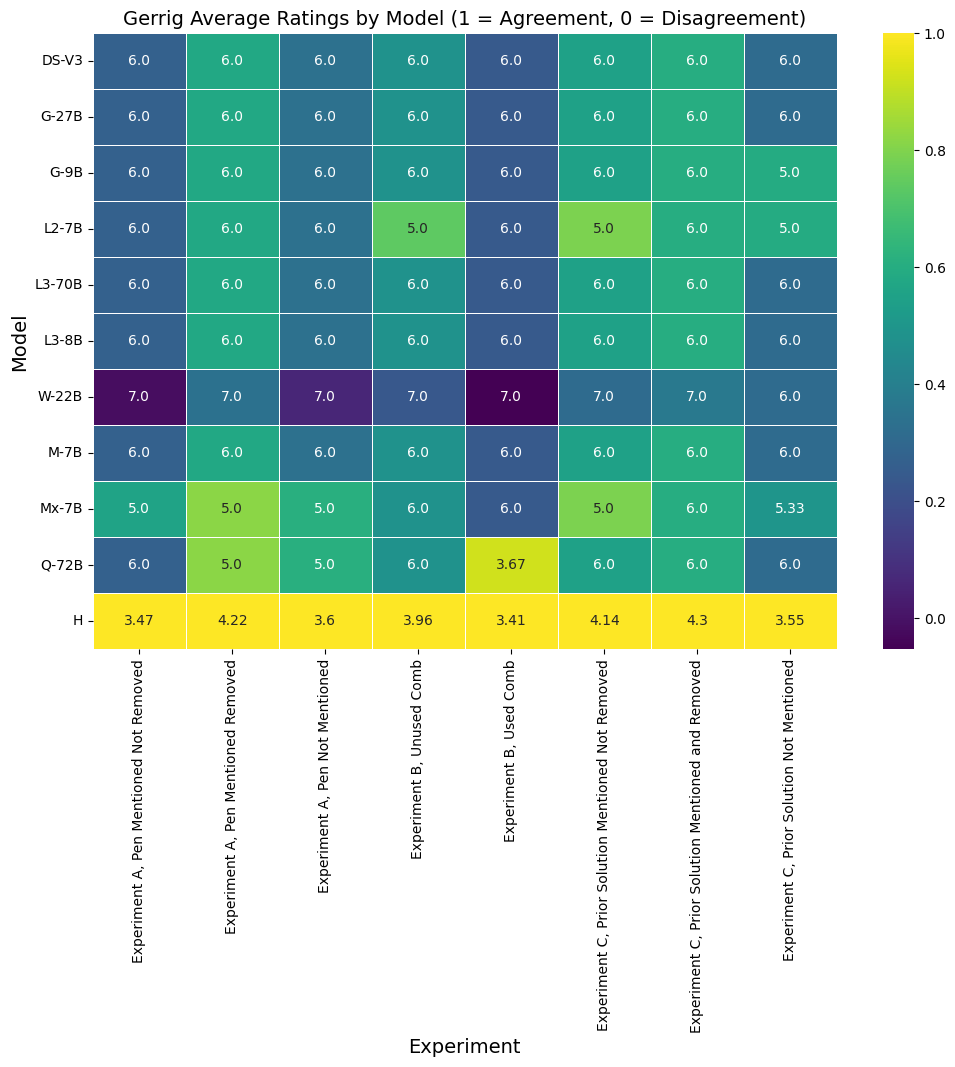

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data = []
models = list(normal_dict.keys())
experiments = list(human_ratings.keys())
shortened_model_names = ["DS-V3", "G-27B", "G-9B", 'L2-7B', 'L3-70B', 'L3-8B', 'W-22B', 'M-7B', 'Mx-7B', 'Q-72B']

actual =[]
for model in models:
    for experiment in experiments:
        llm_rating = normal_dict[model].get(experiment, np.nan)
        human_rating = human_ratings.get(experiment, np.nan)
        
        if not np.isnan(llm_rating) and not np.isnan(human_rating):
            proximity = 1 - abs(llm_rating - human_rating) / max(1, abs(human_rating))
            data.append([model, experiment, llm_rating, human_rating, proximity])

df = pd.DataFrame(data, columns=["Model", "Experiment", "LLM Rating", "Human Rating", "Proximity"])
human_row = pd.DataFrame([["Human", experiment, np.nan, human_ratings[experiment], 1.0] for experiment in experiments], columns=["Model", "Experiment", "LLM Rating", "Human Rating", "Proximity"])

df = pd.concat([df, human_row], ignore_index=True)

df_pivot = df.pivot(index="Model", columns="Experiment", values="Proximity")
df_pivot = df_pivot.reindex(df_pivot.index.tolist() + ['Human'])
df_pivot = df_pivot[~df_pivot.index.duplicated(keep='last')]

annot_data = df.pivot(index="Model", columns="Experiment", values="LLM Rating").reindex(df_pivot.index)
human_data = df.pivot(index="Model", columns="Experiment", values="Human Rating").reindex(df_pivot.index)

annot_data_rounded = annot_data.round(2)
human_data_rounded = human_data.round(2)

annot_matrix = annot_data_rounded.astype(str)
annot_matrix.loc['Human', :] = human_data_rounded.loc['Human'].astype(str)

plt.figure(figsize=(12, 8))
sns.heatmap(df_pivot, annot=annot_matrix, cmap="viridis", fmt="", linewidths=0.5, yticklabels=shortened_model_names + ["H"],
            annot_kws={"size": 10, "va": "center", "ha": "center"})

plt.title(f'Gerrig Average Ratings by Model (1 = Agreement, 0 = Disagreement)', fontsize=14)
plt.xlabel("Experiment", fontsize=14)
plt.ylabel("Model", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


In [8]:
import csv
import json
import os

def process_experiment_data(source):
    source_path = f"{os.path.dirname(os.path.abspath(os.getcwd()))}/../data/{source}"
    
    experiment_data = {}

    with open(source_path, mode='r', encoding='utf-8') as file:
        reader = csv.reader(file)
        next(reader)
        
        for row in reader:
            if len(row) < 5:
                continue  
            if row[0] != "":
                experiment = row[0] + ", "+  row[1]
                attack = row[2]     
                value = row[5] 

                if experiment not in experiment_data:
                    experiment_data[experiment] = {}
                
                experiment_data[experiment][attack] = value

    return experiment_data

# Example usage
source = "gerrig_results.csv"
result = process_experiment_data(source)

print(result)


{'Experiment A, Pen Mentioned Not Removed': {'antonym_replacement': '5.777777777777778', 'caesar_cipher': '5.875', 'change_character_names': '5.7407407407407405', 'context_removal': '5.805555555555556', 'distraction_insertion': '5.62962962962963', 'introduce_typos': '5.893518518518519', 'shuffle_sentences': '6.111111111111111', 'swap_words': '6.111111111111111', 'synonym_replacement': '6.1157407407407405', 'word_swap_embedding': '6.0', 'word_swap_homoglyph': '5.666666666666667'}, 'Experiment A, Pen Mentioned Removed': {'antonym_replacement': '5.851851851851852', 'caesar_cipher': '6.0', 'change_character_names': '5.703703703703703', 'context_removal': '5.8842592592592595', 'distraction_insertion': '6.111111111111111', 'introduce_typos': '6.0', 'shuffle_sentences': '6.166666666666667', 'swap_words': '6.0', 'synonym_replacement': '6.083333333333333', 'word_swap_embedding': '6.0', 'word_swap_homoglyph': '6.0'}, 'Experiment A, Pen Not Mentioned': {'antonym_replacement': '5.7407407407407405'

In [9]:
import json
from collections import defaultdict

def average_experiment_scores(llm_results):
    experiment_totals = defaultdict(lambda: {"sum": 0, "count": 0})

    for llm, experiments in llm_results.items():
        for experiment, score in experiments.items():
            experiment_totals[experiment]["sum"] += score
            experiment_totals[experiment]["count"] += 1

    averaged_experiments = {
        experiment: data["sum"] / data["count"]
        for experiment, data in experiment_totals.items()
    }

    return averaged_experiments

averaged_scores = average_experiment_scores(normal_dict)
print(averaged_scores)


{'Experiment A, Pen Mentioned Not Removed': 6.0, 'Experiment A, Pen Mentioned Removed': 5.9, 'Experiment A, Pen Not Mentioned': 5.9, 'Experiment B, Unused Comb': 6.0, 'Experiment B, Used Comb': 5.866666666666666, 'Experiment C, Prior Solution Mentioned and Removed': 6.1, 'Experiment C, Prior Solution Mentioned Not Removed': 5.9, 'Experiment C, Prior Solution Not Mentioned': 5.733333333333333}


{'antonym_replacement': '5.777777777777778', 'caesar_cipher': '5.875', 'change_character_names': '5.7407407407407405', 'context_removal': '5.805555555555556', 'distraction_insertion': '5.62962962962963', 'introduce_typos': '5.893518518518519', 'shuffle_sentences': '6.111111111111111', 'swap_words': '6.111111111111111', 'synonym_replacement': '6.1157407407407405', 'word_swap_embedding': '6.0', 'word_swap_homoglyph': '5.666666666666667'}
dict_values([{'antonym_replacement': '5.777777777777778', 'caesar_cipher': '5.875', 'change_character_names': '5.7407407407407405', 'context_removal': '5.805555555555556', 'distraction_insertion': '5.62962962962963', 'introduce_typos': '5.893518518518519', 'shuffle_sentences': '6.111111111111111', 'swap_words': '6.111111111111111', 'synonym_replacement': '6.1157407407407405', 'word_swap_embedding': '6.0', 'word_swap_homoglyph': '5.666666666666667'}, {'antonym_replacement': '5.851851851851852', 'caesar_cipher': '6.0', 'change_character_names': '5.70370370

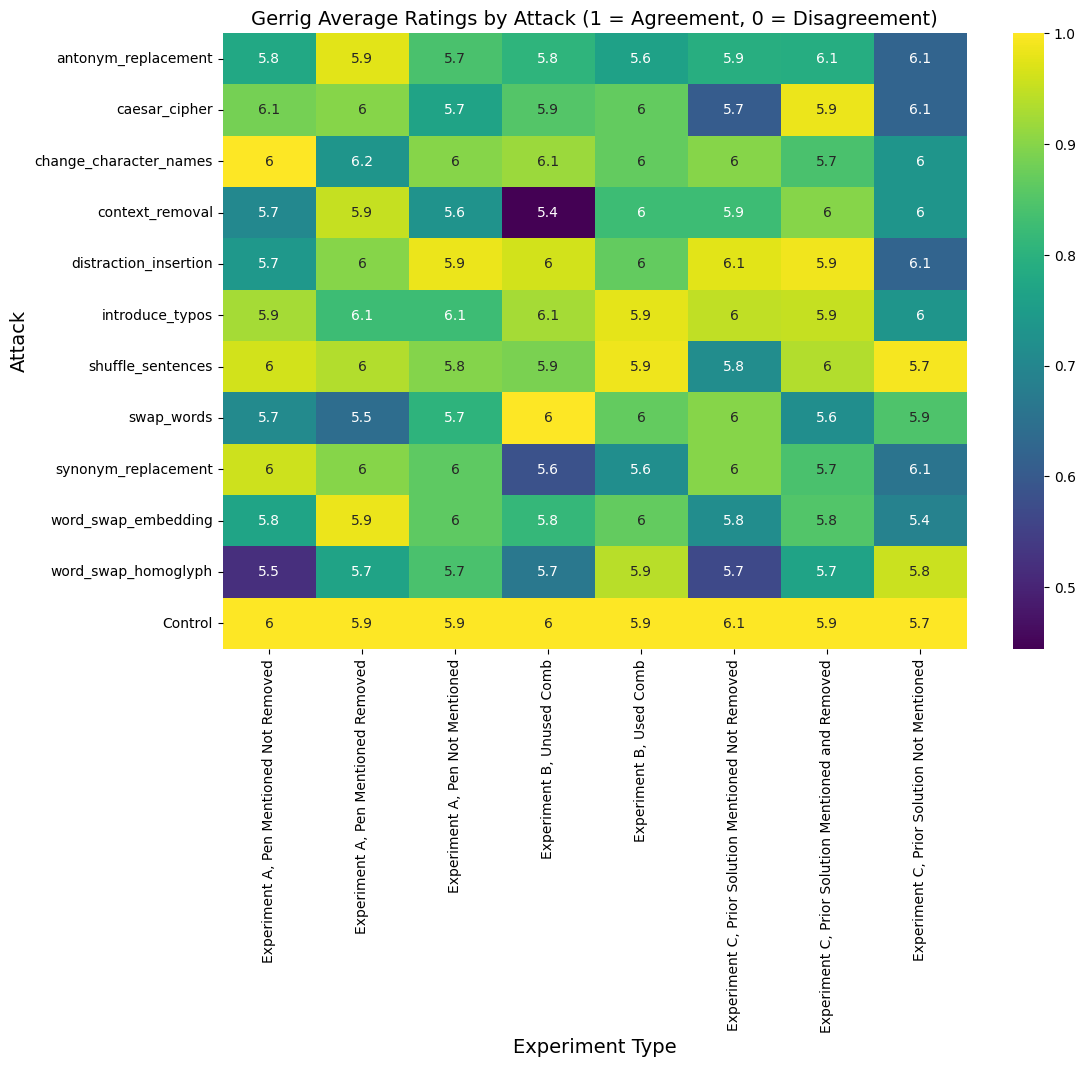

In [10]:

control_ratings = averaged_scores.values()
experim = list(result.keys())
attack_names = list(result["Experiment A, Pen Mentioned Not Removed"].keys()) + ["Control"]
print(result["Experiment A, Pen Mentioned Not Removed"])
llm = result.values()
print(llm)
list_values = list(llm)
flattened_values = [float(v) for d in list_values for v in d.values()]
llm_ratings = np.array(list(flattened_values) + list(control_ratings))
print(llm_ratings)

control_ratings = np.array(list(control_ratings))

llm_ratings = np.array(llm_ratings).reshape(12, 8)

agreement_matrix = 1 - (np.abs(llm_ratings - control_ratings))

plt.figure(figsize=(12,8))
ax = sns.heatmap(agreement_matrix, annot=llm_ratings, cmap="viridis", cbar=True, linewidths=0, yticklabels=attack_names, xticklabels=experim)

plt.title(f"Gerrig Average Ratings by Attack (1 = Agreement, 0 = Disagreement)", fontsize=14)
plt.xlabel("Experiment Type", fontsize=14)
plt.ylabel("Attack", fontsize=14)
plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# experiments = list(human_ratings.keys())
# llm_values1 = [llm_ratings1.get(exp, 0) for exp in experiments]
# llm_values2 = [llm_ratings2.get(exp, 0) for exp in experiments]
# llm_values3 = [llm_ratings3.get(exp, 0) for exp in experiments]
# human_values = [human_ratings.get(exp, 0) for exp in experiments]

# llm_means = np.mean([llm_values1, llm_values2, llm_values3], axis=0)
# llm_stds = np.std([llm_values1, llm_values2, llm_values3], axis=0)
# bar_width = 0.35
# index = np.arange(len(experiments))
# fig, ax = plt.subplots(figsize=(12, 8))
# ax.bar(index, human_values, bar_width, label='Human Ratings')
# ax.bar(index + bar_width, llm_means, bar_width, yerr=llm_stds, capsize=5, label='LLM Ratings (Avg)', color='orange')
# ax.set_xlabel('Experiments')
# ax.set_ylabel('Suspense Ratings')
# ax.set_title('Human vs LLM Suspense Ratings')
# ax.set_xticks(index + bar_width / 2)
# ax.set_xticklabels(experiments, rotation=45, ha='right', fontsize=10)
# ax.legend()
# plt.tight_layout()
# plt.show()

In [12]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# experiments = list(human_ratings.keys())
# llm_values1 = [llm_ratings1.get(exp, 0) for exp in experiments]
# llm_values2 = [llm_ratings2.get(exp, 0) for exp in experiments]
# llm_values3 = [llm_ratings3.get(exp, 0) for exp in experiments]
# human_values = [human_ratings.get(exp, 0) for exp in experiments]

# llm_means = np.mean([llm_values1, llm_values2, llm_values3], axis=0)

# differences = []
# for i in range(len(llm_means)):
#     diff_llm = abs(llm_means[i] - human_values[i])
#     similarity = 1 - (diff_llm / 7)
#     differences.append(similarity)
# heatmap_data = np.zeros((1, len(experiments)))
# for i in range(len(differences)):
#     heatmap_data[0, i] = differences[i] 


# plt.figure(figsize=(12, 2))
# sns.heatmap(heatmap_data, annot=True, cmap="viridis", cbar_kws={'label': 'Difference (Human - LLM)', 'ticks': [0, 0.5, 1]}, xticklabels=experiments, yticklabels=["1"], cbar=True, vmin=0, vmax=1)
# plt.xlabel('Experiments')
# plt.ylabel('Human-LLM Agreement')
# plt.title('Agreement Between Human and LLM Suspense Ratings (1 = Agreement , 0 = Disagreement)')
# plt.tight_layout()
# plt.show()


In [13]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# experiments = list(human_ratings.keys())
# llm_values1 = [llm_ratings1.get(exp, 0) for exp in experiments]
# llm_values2 = [llm_ratings2.get(exp, 0) for exp in experiments]
# llm_values3 = [llm_ratings3.get(exp, 0) for exp in experiments]
# human_values = [human_ratings.get(exp, 0) for exp in experiments]

# llm_means = np.mean([llm_values1, llm_values2, llm_values3], axis=0)
# mean = 3.5
# differences = []

# for i in range(0, len(llm_means)):
#     diff_llm = llm_means[i] - mean
#     diff_human = human_values[i] - mean
    
#     if diff_llm > 0:
#         differences.append(1)
#     elif diff_llm == 0:
#         differences.append(0.5)
#     else:
#         differences.append(0)

# heatmap_data = np.zeros((2, len(experiments))) 
# for i, diff in enumerate(differences):
#     heatmap_data[1, i] = diff
#     if diff_human > 0:
#         heatmap_data[0, i] = 1
#     elif diff_human == 0:
#         heatmap_data[0, i] = 0.5
#     else:
#         heatmap_data[1, i] = 0
# plt.figure(figsize=(12, 4))
# sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar_kws={'label': 'Suspenseful or not', 'ticks': [0, 0.5, 1]}, 
#             xticklabels=experiments, yticklabels=["Human", "LLM"], cbar=True, vmin=0, vmax=1, linewidths=0.5)
# plt.xlabel('Experiments')
# plt.ylabel('Human & LLM')
# plt.title('Suspense characteristic of the Experiments')
# plt.tight_layout()
# plt.show()
